In [1]:
# import numpy as np
# import re

# ptrn = (r'BLOCK: offset: (?P<offset>\d+) len: (?P<len>\d+) phased: (?P<phased>\d+) ' +
#                  r'SPAN: (?P<span>\d+) fragments (?P<fragments>\d+)')

# def parse_hap_file(fn):
#     with open(fn) as f:
#         for l in f:
#             if l.startswith('BLOCK'):
#                 g = re.match(ptrn, l)
#                 yield g.group('len')

# ema_blocks = np.fromiter(parse_hap_file('EMA_100pc-downsample-strelka2.hap'), int)
# bwa_blocks = np.fromiter(parse_hap_file('TruSeq_100pc-downsample-strelka2.hap'), int)


In [16]:
from cyvcf2 import VCF

def parse_vcf_file(fn):
    blocks = []
    
    current_ps = None
    for rec in VCF(fn):
        ps = None
        if 'PS' in rec.FORMAT:
            ps = rec.format('PS', int)[0][0]
        #print(ps, current_ps, ps == current_ps)
        if ps is not None and current_ps is not None and ps == current_ps:
            blocks[-1] += 1
        else:
            blocks.append(1)
            current_ps = ps
    return sorted(blocks, reverse=True)

ema_blocks = parse_vcf_file('EMA_100pc-downsample-strelka2.phased.TP.vcf')
bwa_blocks = parse_vcf_file('BWA_100pc-downsample-strelka2.phased.TP.vcf')



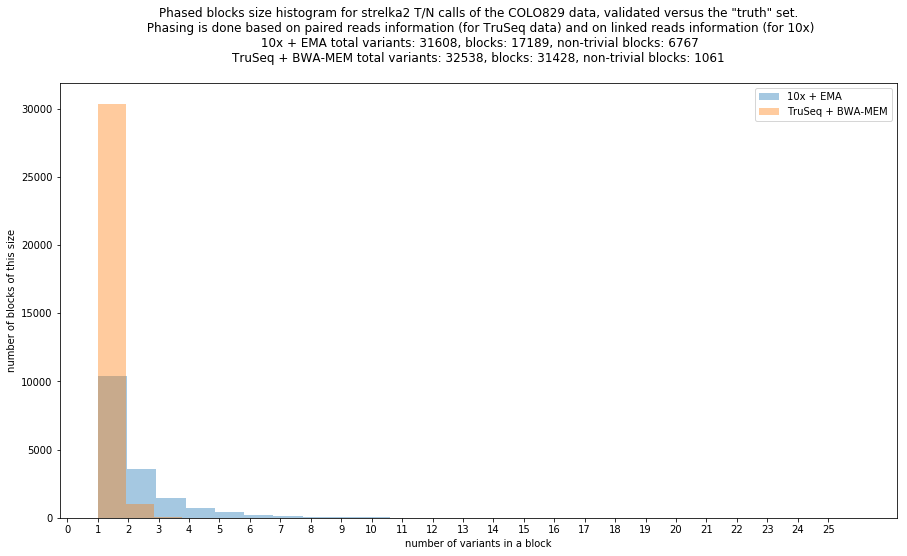

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,8))

bins = max(ema_blocks[0], bwa_blocks[0])
for x, l in [(ema_blocks, "10x + EMA"), (bwa_blocks, "TruSeq + BWA-MEM")]:
    ax = sns.distplot(x, label=l, kde=False, bins=x[0])
    ax.set_xticks(np.arange(0, bins, step=1))

plt.xlabel('number of variants in a block')
plt.ylabel('number of blocks of this size')
plt.title(f'Phased blocks size histogram for strelka2 T/N calls of the COLO829 data, '
          f'validated versus the "truth" set.\n '
          f'Phasing is done based on paired reads information (for TruSeq data) and on linked reads '
          f'information (for 10x)\n '
          f'10x + EMA total variants: {sum(ema_blocks)}, blocks: {len(ema_blocks)}, '
          f'non-trivial blocks: {len([b for b in ema_blocks if b != 1])}\n'
          f'TruSeq + BWA-MEM total variants: {sum(bwa_blocks)}, blocks: {len(bwa_blocks)}, '
          f'non-trivial blocks: {len([b for b in bwa_blocks if b != 1])}\n'
          )
plt.legend()
pass
